In [55]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
from scipy.interpolate import interp1d
import jax.numpy as jnp
import jax

from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data
from loss import create_loss
from network import init_net_orth, compute_end_to_end, compute_factor, compress_network
from solver import train
from utils import compose, svd

In [56]:
key = PRNGKey(0)

# Simulated Data
d = 1000
r = 10

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

loss_fn = create_loss(target)
e2e_loss_fn = compose(loss_fn, compute_end_to_end)

In [57]:
depth = 3
init_type = "orth"
init_scale = 1e-3

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-10
step_size = 1e3
n_outer_loops = 5000
n_inner_loops = 200

In [58]:
orig_step_size = step_size
orig_result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=orig_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [59]:
V = compute_factor(init_weights=init_weights, e2e_loss_fn=e2e_loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights=init_weights, V=V, grad_rank=r)

In [60]:
prop = 0
comp_step_size = [prop * step_size] + (depth * [step_size]) + [prop * step_size]
comp_result = train(
    init_weights=comp_init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=comp_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [116]:
orig_weights = orig_result['weights']
comp_weights = comp_result['weights']
orig_end_to_end = [compute_end_to_end(w).reshape(-1) for w in orig_weights]
comp_end_to_end = [compute_end_to_end(w).reshape(-1) for w in comp_weights]
optimal_e2e = orig_end_to_end[-1]

displacement = (orig_end_to_end[0] - optimal_e2e).reshape(-1, 1)
random_dir = jax.random.normal(key=PRNGKey(1), shape=(d**2, 1))
proj = jnp.linalg.svd(jnp.concatenate([displacement, random_dir], axis=1), full_matrices=False)[0]
# proj = jnp.concatenate([displacement, random_dir], axis=1)
# most_changing_indices = jnp.argpartition(displacement, -2)[-2:]
# proj = jnp.zeros(shape=(d**2, 2)).at[most_changing_indices, jnp.arange(2)].set(1)

# key, subkey = split(key)
# proj = jnp.linalg.svd(jax.random.normal(key=subkey, shape=(d**2, 2)), full_matrices=False)[0]

In [131]:
pairs = []
for e2e in orig_end_to_end:
    pairs.append(proj.T @ (e2e - optimal_e2e))
pairs = jnp.array(pairs)
pairs = pairs[-10:]
x = pairs[:, 0]
y = pairs[:, 1]
n = jnp.arange(x.shape[0])
x_spline = interp1d(n, x,kind='quadratic')

n_ = np.linspace(n.min(), n.max(), 500)
y_spline = interp1d(n, y,kind='quadratic')

x_ = x_spline(n_)
y_ = y_spline(n_)

In [121]:
t1vals = jnp.linspace(-1.5, 1.5)
t2vals = jnp.linspace(-1.5, 1.5)
lossvals = []
for t1 in tqdm(t1vals):
    row = []
    for t2 in t2vals:
        point = (optimal_e2e + t1 * proj[:, 0] + t2 * proj[:, 1]).reshape(d, d)
        row.append(loss_fn(point))
        
    lossvals.append(row)
    
lossvals = jnp.array(lossvals)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.87it/s]


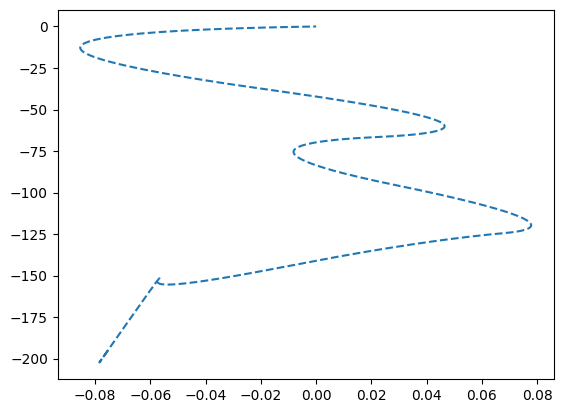

In [132]:
plt.plot(x_, y_, '--')
# plt.contour(t1vals, t2vals, lossvals)

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt


x = np.array([-31,-30,-30,-32,-36,-39])
n = np.arange(x.shape[0]) 
y = np.array([60,62,64,65,64,64])


x_spline = interp1d(n, x,kind='cubic')

n_ = np.linspace(n.min(), n.max(), 500)
y_spline = interp1d(n, y,kind='cubic')

x_ = x_spline(n_)
y_ = y_spline(n_)



plt.plot(x_, y_)

plt.plot(x,y);

In [ ]:
A = jnp.linalg.svd(generate_data(key=PRNGKey(11), shape=(3, d*d)), full_matrices=False)[2]

In [ ]:
red_orig_end_to_end = jnp.array([A @ w for w in orig_end_to_end])
red_comp_end_to_end = jnp.array([A @ w for w in comp_end_to_end])

In [ ]:
fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(121, projection='3d')

ax.plot(red_orig_end_to_end[:, 0], red_orig_end_to_end[:, 1], red_orig_end_to_end[:, 2], linewidth=5, linestyle='--', label='Original')
ax.plot(red_comp_end_to_end[:, 0], red_comp_end_to_end[:, 1], red_comp_end_to_end[:, 2], linewidth=3, linestyle='-', label='Compressed')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.legend(fontsize=12)
ax.set_box_aspect(None, zoom=1.2)

ax = fig.add_subplot(122)

ax.semilogy(orig_result['time'], orig_result['train_loss'], linewidth=5, label='Original')
ax.semilogy(comp_result['time'], comp_result['train_loss'], linewidth=3, label='Compressed')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.legend(fontsize=12)

# plt.savefig('figs/equiv_traj_l2.png', dpi=300, bbox_inches='tight')